# Covid Analysis III
### Aug 2021
* Instructor: Ashish Bujari
* Author(s): Linqi Yang

## Hive

In [1]:
# wget -qO- https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv | hdfs dfs -put - /user/$USER/data/crimes.csv

# hdfs dfs -cat /user/$USER/data/crimes.csv | wc -l

# use linqiyang;

# create external table chicago_crimes (id INT, case_number STRING, time STRING, block STRING, iucr STRING, primary_type STRING, description STRING, location_description STRING, arrest STRING, domestic STRING, beat STRING, district STRING, ward INT, community_area STRING, fbi_code STRING, x_coordinate INT, y_coordinate INT, year INT, updated_on STRING, latitude FLOAT, longitude FLOAT, location STRING)
# ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' STORED AS TEXTFILE
# LOCATION '/user/linqiyang/data/'
# tblproperties("skip.header.line.count"="1");

# LOAD DATA INPATH '/user/linqiyang/data/crimes.csv' INTO TABLE chicago_crimes;

## the most recent date of the crimes and the type
# SELECT MAX(time) FROM chicago_crimes where year = 2021;
# SELECT distinct(primary_type), time FROM chicago_crimes where time = '07/07/2021 12:48:00 AM';

## the top 5 primary crime types
# SELECT primary_type, COUNT(*) AS CNT FROM chicago_crimes GROUP BY primary_type ORDER BY CNT DESC LIMIT 5;

## location description that has the highest number of homicides
# SELECT location_description, COUNT(*) AS CNT FROM chicago_crimes WHERE primary_type = 'HOMICIDE' GROUP BY location_description ORDER BY CNT DESC LIMIT 1;

## the most dangerous police districts
# SELECT district, COUNT(*) AS CNT FROM chicago_crimes GROUP BY district ORDER BY CNT DESC Limit 1;

## the average number assaults per month that occurred in 2019
# SELECT COUNT(*)/12 FROM chicago_crimes WHERE primary_type = 'ASSAULT' AND year = 2019;

## has that number increased since the prior period
# SELECT COUNT(*)/12 FROM chicago_crimes WHERE primary_type = 'ASSAULT' AND year = 2018;

# CREATE TABLE dataviz AS SELECT community_area, primary_type, COUNT(*) FROM chicago_crimes GROUP BY community_area, primary_type;

# hive -e "SELECT * from linqiyang.dataviz" >> dataviz.txt

## PySpark
### Print summary statistics

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ChicagoChrimes').getOrCreate()

df = spark.read.csv("/user/linqiyang/data/crimes.csv", inferSchema=True, header=True)
df.summary()

DataFrame[summary: string, ID: string, Case Number: string, Date: string, Block: string, IUCR: string, Primary Type: string, Description: string, Location Description: string, Beat: string, District: string, Ward: string, Community Area: string, FBI Code: string, X Coordinate: string, Y Coordinate: string, Year: string, Updated On: string, Latitude: string, Longitude: string, Location: string]

### Drop the columns beat, ward, latitude and longitude columns

In [2]:
df = df.drop('Beat', 'Ward', 'Latitude', 'Longitude')

### Convert remaining columns to appropriate data types

In [3]:
# convert column 'Date' and 'Updated On' from string to timestamp
from pyspark.sql.functions import *
df = df.withColumn('Date', to_date(to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a')))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Location: string (nullable = true)



### Add a month column and community name

In [4]:
# add column 'month'
df = df.withColumn('Month', month('Date'))

# add column 'community name' using joins
community = spark.read.csv("/user/linqiyang/data/community.csv", inferSchema=True, header=True)
community = community.select('community_area', 'community_area_name')
df = df.join(community, df['Community Area'] == community['community_area'])
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- community_area_name: string (nullable = true)



### Group and count crimes where description begins with the word “aggravated”

In [5]:
df.filter(df.Description.startswith('AGGRAVATED')).groupBy('Description').count().show(5)

+--------------------+-----+
|         Description|count|
+--------------------+-----+
|AGGRAVATED PO:KNI...|  546|
|AGGRAVATED: OTHER...|83837|
|AGGRAVATED DOMEST...|  942|
|AGGRAVATED POLICE...|  111|
|AGGRAVATED DOMEST...|  136|
+--------------------+-----+
only showing top 5 rows



### Which crime type is the most prevalent in apartments and which community has it occurred the most

In [6]:
# most prevalent crime type in apartment
df.filter(df['Location Description'] == 'APARTMENT').groupBy('Primary Type').count().orderBy('count', ascending=0).show(1)

+------------+------+
|Primary Type| count|
+------------+------+
|     BATTERY|262102|
+------------+------+
only showing top 1 row



In [7]:
# community with the most 'BATTERY'
df.filter(df['Primary Type'] == 'BATTERY').groupBy('community_area_name').count().orderBy('count', ascending=0).show(1)

+-------------------+-----+
|community_area_name|count|
+-------------------+-----+
|             Austin|86130|
+-------------------+-----+
only showing top 1 row



### What is the maximum number of weapons violations per month that occurred in 2020

In [8]:
df.filter(df['Primary Type'] == 'WEAPONS VIOLATION').filter(df.Year == 2020).groupBy('Month').count().orderBy('count', ascending=0).show(1)

+-----+-----+
|Month|count|
+-----+-----+
|    8|  982|
+-----+-----+
only showing top 1 row



### What percentage of the domestic crimes led to an arrest

In [9]:
df_2d = df.groupBy('Domestic').pivot('Arrest').count()
df_2d.filter(df_2d.Domestic == True).withColumn('Percentage', df_2d.true / (df_2d.true + df_2d.false)).select('Percentage').show()

+-------------------+
|         Percentage|
+-------------------+
|0.19239748714524785|
+-------------------+



### Which day of the week and which month have the most and the least crimes on average

In [10]:
df = df.dropna(subset='Date').withColumn('Weekday', dayofweek('Date'))

# day of week with the most crimes
df.groupBy('Weekday').count().orderBy('count', ascending=0).show(1)

+-------+-------+
|Weekday|  count|
+-------+-------+
|      6|1014844|
+-------+-------+
only showing top 1 row



In [11]:
# day of week with the least crimes
df.groupBy('Weekday').count().orderBy('count', ascending=1).show(1)

+-------+------+
|Weekday| count|
+-------+------+
|      1|917426|
+-------+------+
only showing top 1 row



In [12]:
# month with the most crimes
df.groupBy('Month').count().orderBy('count', ascending=0).show(1)

+-----+------+
|Month| count|
+-----+------+
|    7|635245|
+-----+------+
only showing top 1 row



In [13]:
# month with the least crimes
df.groupBy('Month').count().orderBy('count', ascending=1).show(1)

+-----+------+
|Month| count|
+-----+------+
|    2|447204|
+-----+------+
only showing top 1 row



### Which date had the most number of homicides in the dataset. How many days passed between this date and the next highest number of homicides

In [14]:
# date with the most homicides
df_2b = df.filter(df['Primary Type'] == 'HOMICIDE').groupBy('Date').count().orderBy('count', ascending=0)
df_2b.show(3)

+----------+-----+
|      Date|count|
+----------+-----+
|2020-05-31|   19|
|2015-09-02|   10|
|2003-07-05|   10|
+----------+-----+
only showing top 3 rows



In [15]:
# days passed
(df_2b.collect()[1]['Date'] - df_2b.collect()[0]['Date']).days

-6175

### Plot a monthly time series line chart of all crimes for the last 3 years

In [16]:
df_3c = df.filter(df.Year >= 2019).groupBy('Year', 'Month').count().toPandas()
df_3c.pivot(index='Month', columns='Year', values='count').plot(kind='line')

### Plot a year over year comparison for 3 years (2018, 2019, 2020) by top 5 crime types

In [17]:
# top 5 crimes
top5 = list(df.filter(df.Year.isin([2018, 2019, 2020])).groupBy('Primary Type').count()\
            .orderBy('count', ascending=0).select('Primary Type').collect()[0:5])
top5 = [i[0] for i in top5]
top5

['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'DECEPTIVE PRACTICE']

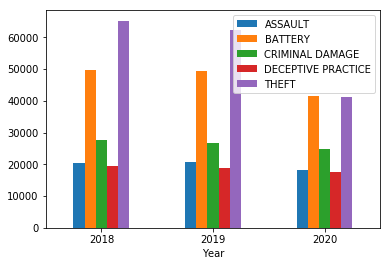

In [18]:
df_3d = df.filter(df.Year.isin([2018, 2019, 2020])).filter(df['Primary Type'].isin(top5)).groupBy('Year').pivot('Primary Type').count().toPandas()
df_3d.plot(kind = 'bar', x='Year', rot='0')

### Calculate the community rank based on total crime figures (highest to lowest)

In [19]:
from pyspark.sql.window import Window
df_4a = df.groupBy('community_area_name').count()
w  = Window.orderBy(df_4a['count'].desc())
df_4a.withColumn('rank', rank().over(w)).show(5)

+-------------------+------+----+
|community_area_name| count|rank|
+-------------------+------+----+
|             Austin|426432|   1|
|    Near North Side|233936|   2|
|        South Shore|221694|   3|
|      Humboldt Park|212842|   4|
|     Near West Side|200654|   5|
+-------------------+------+----+
only showing top 5 rows



### Calculate a rolling 7 day sum of crimes over time within each community

In [20]:
df_4b = df.groupBy('community_area_name', 'Date').count().orderBy('community_area_name', 'Date').dropna()
days = lambda i: i * 86400
w = (Window().partitionBy(col('community_area_name')).orderBy(col('Date').cast('timestamp').cast('long')).rangeBetween(-days(7), 0))
df_4b = df_4b.withColumn('rolling sum', sum('count').over(w))
df_4b.show()

+-------------------+----------+-----+-----------+
|community_area_name|      Date|count|rolling sum|
+-------------------+----------+-----+-----------+
|         North Park|2001-01-01|    2|          2|
|         North Park|2001-01-05|    1|          3|
|         North Park|2001-01-24|    1|          1|
|         North Park|2001-03-22|    1|          1|
|         North Park|2001-08-19|    1|          1|
|         North Park|2001-09-01|    1|          1|
|         North Park|2001-10-01|    1|          1|
|         North Park|2001-10-09|    1|          1|
|         North Park|2001-10-11|    1|          2|
|         North Park|2001-11-02|    1|          1|
|         North Park|2001-11-16|    1|          1|
|         North Park|2001-12-01|    2|          2|
|         North Park|2001-12-04|    1|          3|
|         North Park|2001-12-09|    1|          2|
|         North Park|2001-12-18|    1|          1|
|         North Park|2001-12-29|    1|          1|
|         North Park|2002-01-20

### Calculate a 7 day moving average and cumulative sum of crimes over time within each community

In [21]:
w = Window().partitionBy(col('community_area_name')).orderBy(col('Date'))
df_4b.withColumn('cumulative sum', sum('count').over(w)).show()

+-------------------+----------+-----+-----------+--------------+
|community_area_name|      Date|count|rolling sum|cumulative sum|
+-------------------+----------+-----+-----------+--------------+
|         North Park|2001-01-01|    2|          2|             2|
|         North Park|2001-01-05|    1|          3|             3|
|         North Park|2001-01-24|    1|          1|             4|
|         North Park|2001-03-22|    1|          1|             5|
|         North Park|2001-08-19|    1|          1|             6|
|         North Park|2001-09-01|    1|          1|             7|
|         North Park|2001-10-01|    1|          1|             8|
|         North Park|2001-10-09|    1|          1|             9|
|         North Park|2001-10-11|    1|          2|            10|
|         North Park|2001-11-02|    1|          1|            11|
|         North Park|2001-11-16|    1|          1|            12|
|         North Park|2001-12-01|    2|          2|            14|
|         

### Cross-tabulate Crime Types vs Location description and visualize it through a heatmap

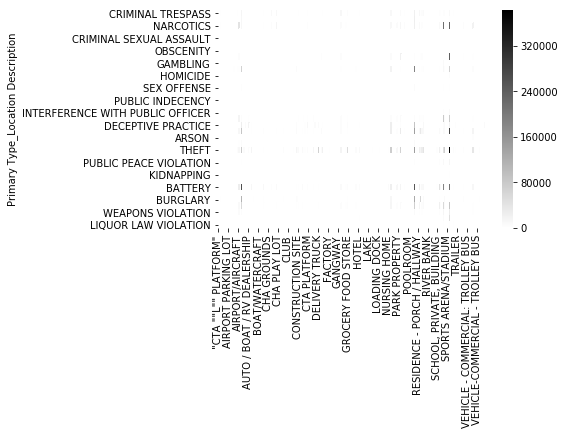

In [22]:
import seaborn as sns
df_4d = df.crosstab('Primary Type', 'Location Description').toPandas()
df_4d.set_index('Primary Type_Location Description', inplace=True)
sns.heatmap(df_4d, cmap='binary')

### Bring in daily Covid cases data from the City of Chicago data portal and load into a table chicago_covid 

In [23]:
covid = spark.read.csv("/user/linqiyang/data/chicago_covid.csv", inferSchema=True, header=True)

### Create summarized daily total counts of the daily crime data by crime type

In [24]:
df_5b = df.groupBy('Date').pivot('Primary Type').count().orderBy('Date').dropna(subset='Date')
df_5b.show(3)

+----------+-----+-------+-------+--------+---------------------------------+-------------------+---------------+-----------------------+-----------------+------------------+--------+--------+-----------------+--------------------------------+------------+----------+--------------------+-------------------+---------+--------------+------------+--------------------------------+---------+--------------------------+------------------------+-------------+------------+----------------+----------------------+---------+-------+-----------+--------+-----+-----------------+
|      Date|ARSON|ASSAULT|BATTERY|BURGLARY|CONCEALED CARRY LICENSE VIOLATION|CRIM SEXUAL ASSAULT|CRIMINAL DAMAGE|CRIMINAL SEXUAL ASSAULT|CRIMINAL TRESPASS|DECEPTIVE PRACTICE|GAMBLING|HOMICIDE|HUMAN TRAFFICKING|INTERFERENCE WITH PUBLIC OFFICER|INTIMIDATION|KIDNAPPING|LIQUOR LAW VIOLATION|MOTOR VEHICLE THEFT|NARCOTICS|NON - CRIMINAL|NON-CRIMINAL|NON-CRIMINAL (SUBJECT SPECIFIED)|OBSCENITY|OFFENSE INVOLVING CHILDREN|OTHER NARCOT

### Join daily total covid cases and death data with daily chicago crimes data starting Jan 2020.

In [25]:
covid = covid.withColumn('Date_covid', to_date(to_timestamp('Date', 'MM/dd/yyyy'))).select('Date_covid', 'Cases - Total', 'Deaths - Total')
df_5c = df_5b.join(covid, df_5b['Date'] == covid['Date_covid'], how='left_outer')
df_5c = df_5c.drop('Date_covid')

### How Covid-19 has impacted various types of crimes compared to previous years

* Percentage Change btw 2020 & 2019 and 2021 & 2020

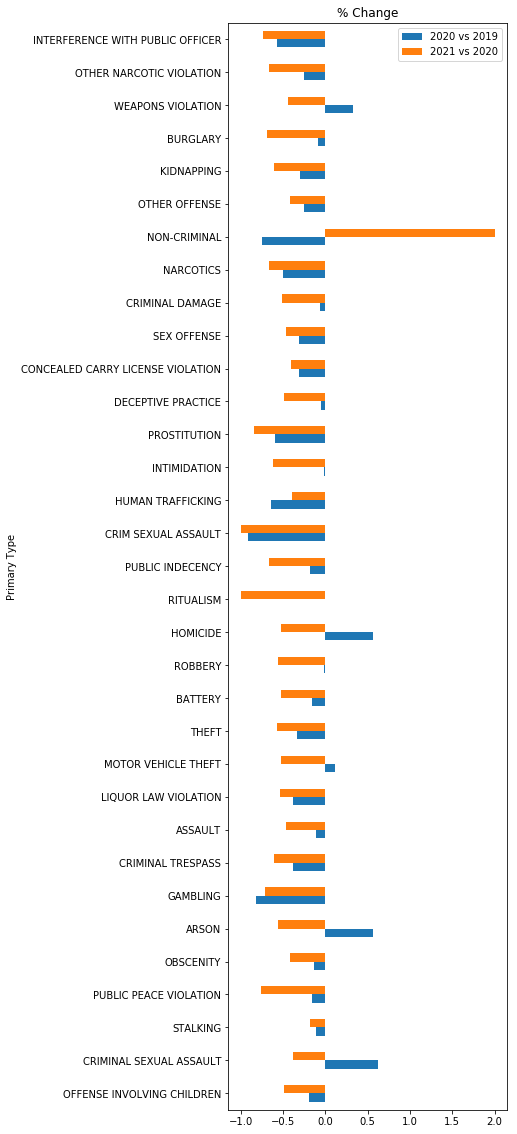

In [26]:
import matplotlib.pyplot as plt
df_change = df.select('Year', 'Primary Type').filter(df.Year >= 2019).groupby('Primary Type').pivot('Year').count().fillna(0)
df_change = df_change.withColumn('2020 vs 2019', (df_change['2020'] - df_change['2019']) / df_change['2019'])\
    .withColumn('2021 vs 2020', (df_change['2021'] - df_change['2020']) / df_change['2020'])\
    .drop('2019', '2020', '2021')\
    .toPandas()\
    .set_index('Primary Type')\
    .plot(kind='barh', figsize=(5, 20))
plt.title('% Change')
plt.show()

* Identify `crime type` with different trends or number of cases from previous years

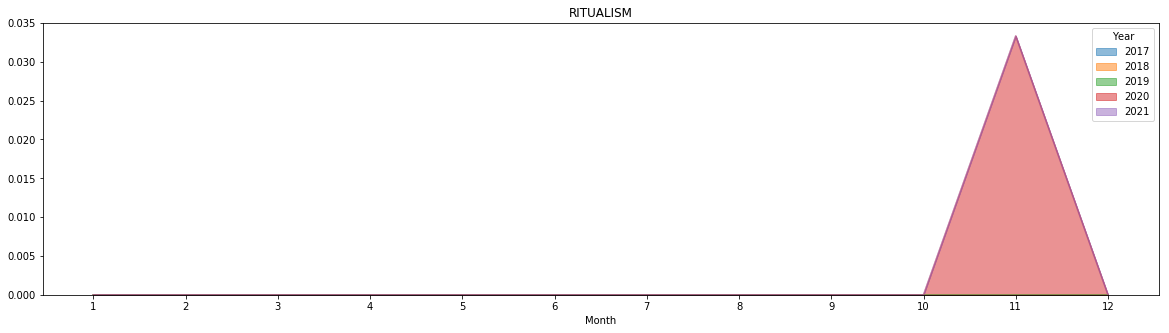

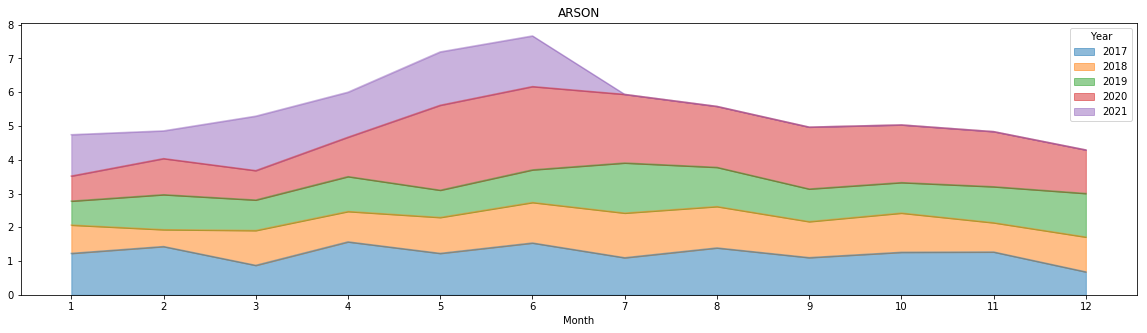

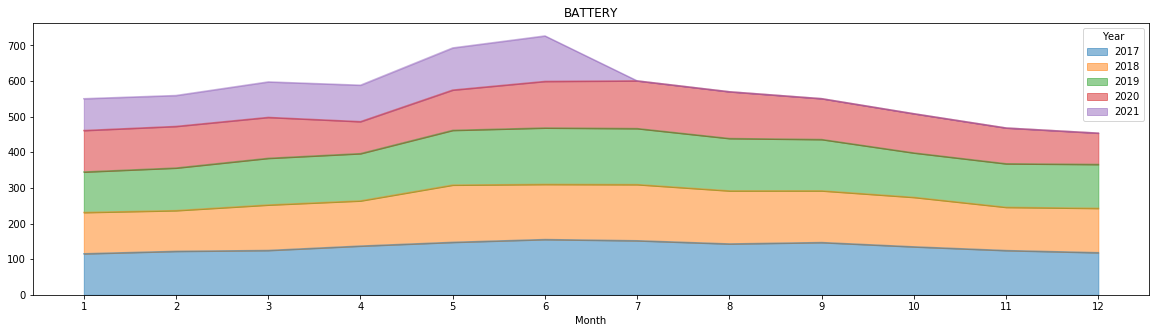

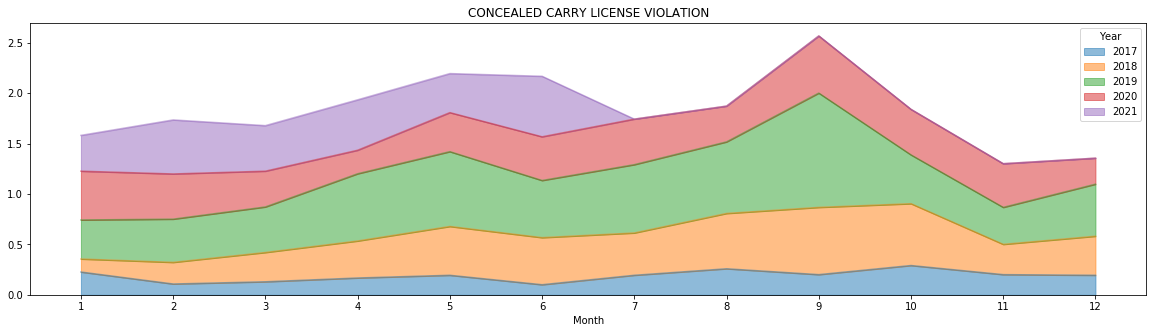

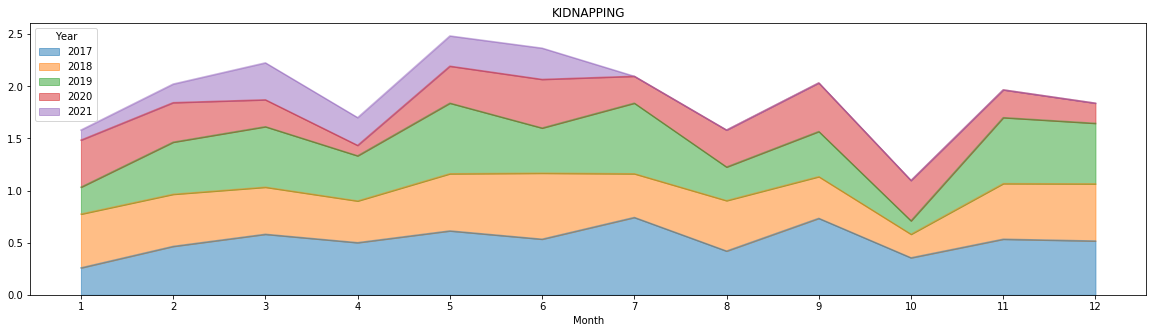

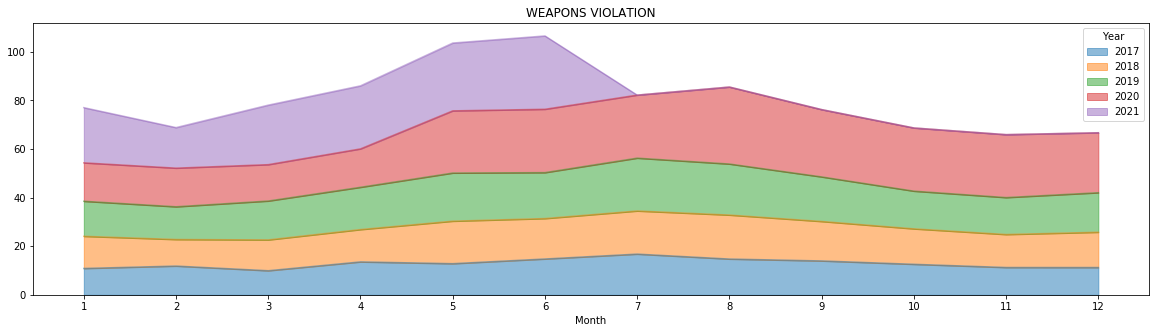

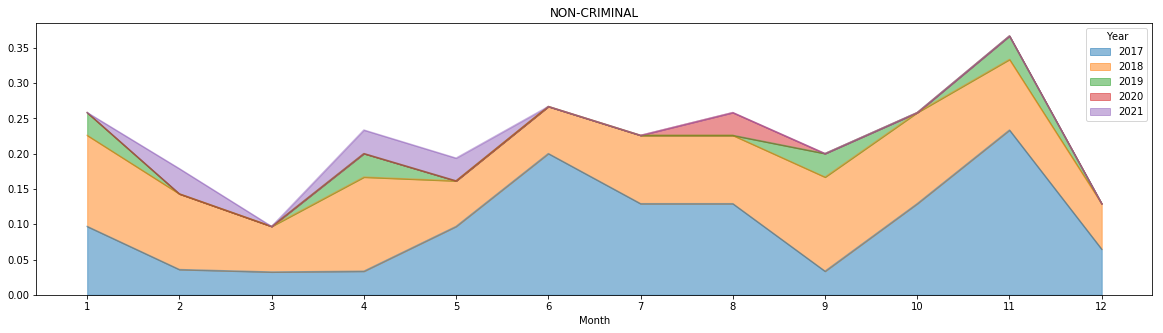

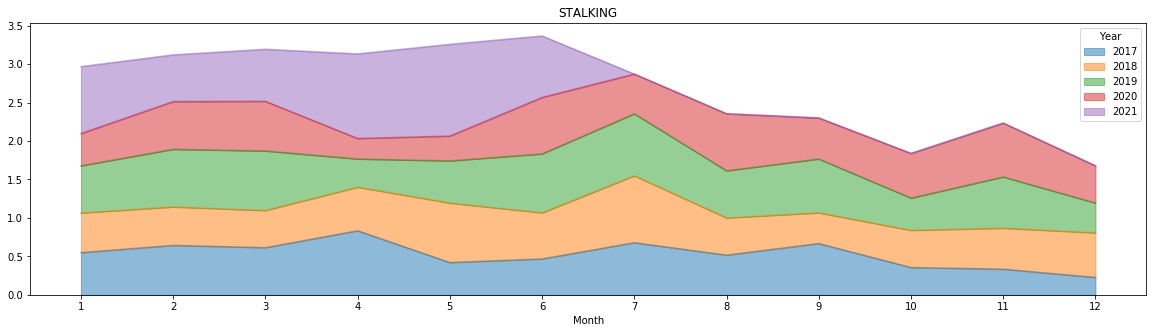

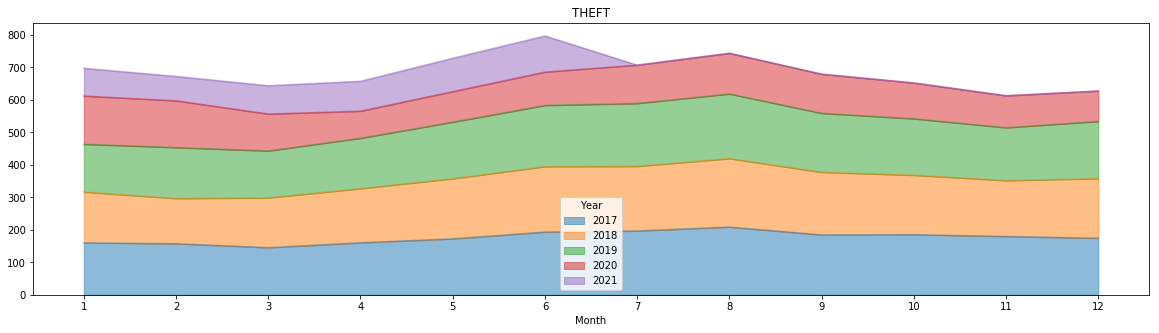

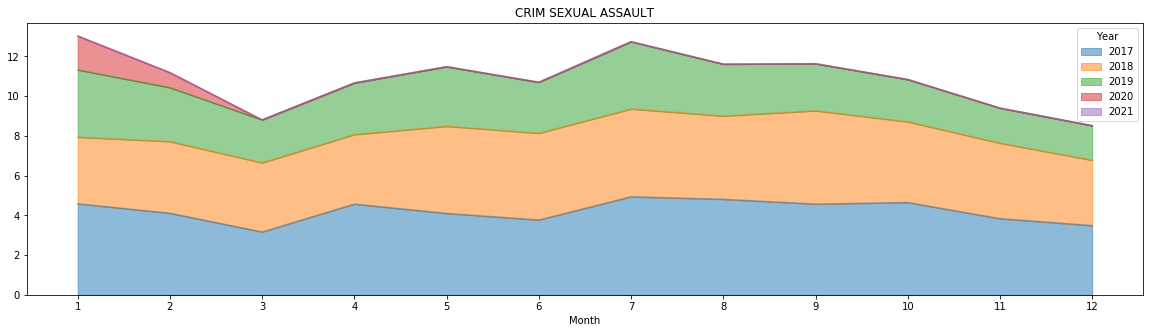

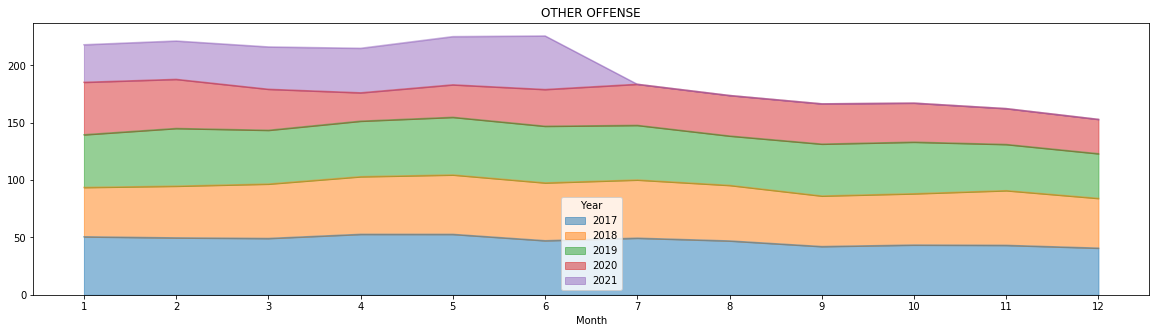

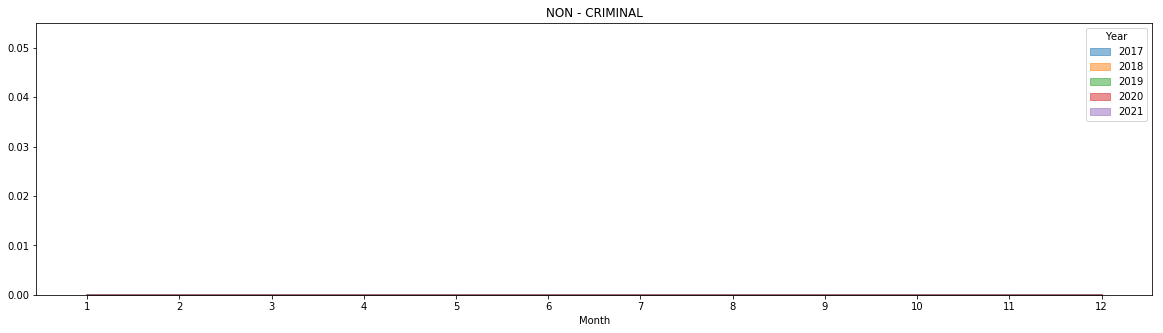

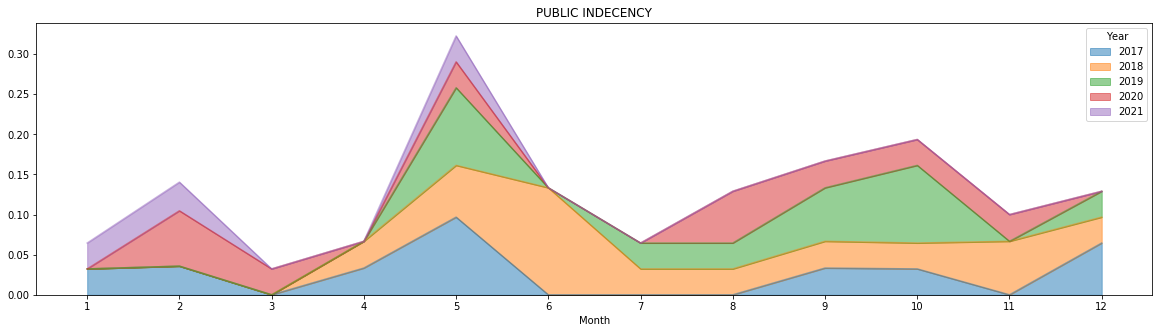

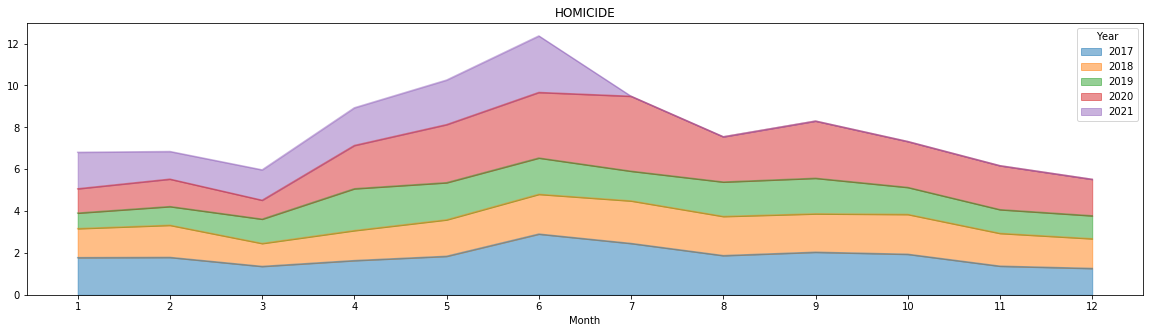

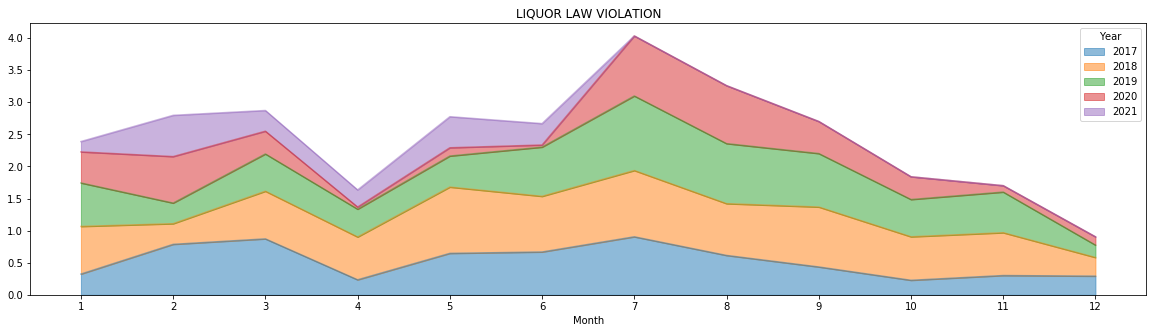

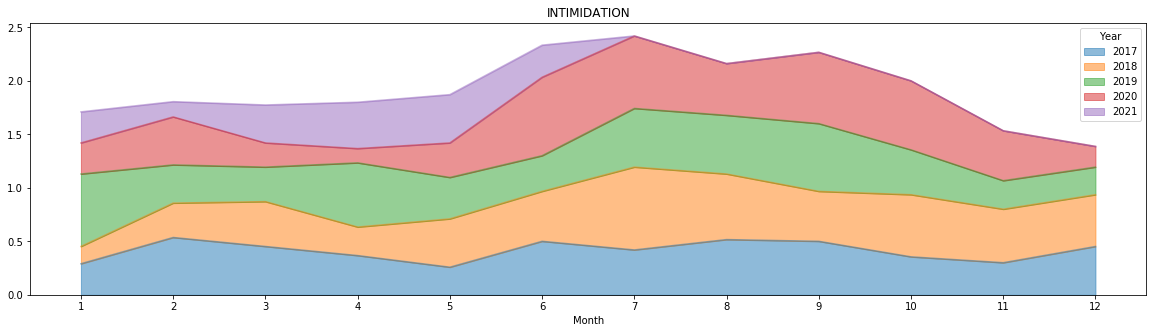

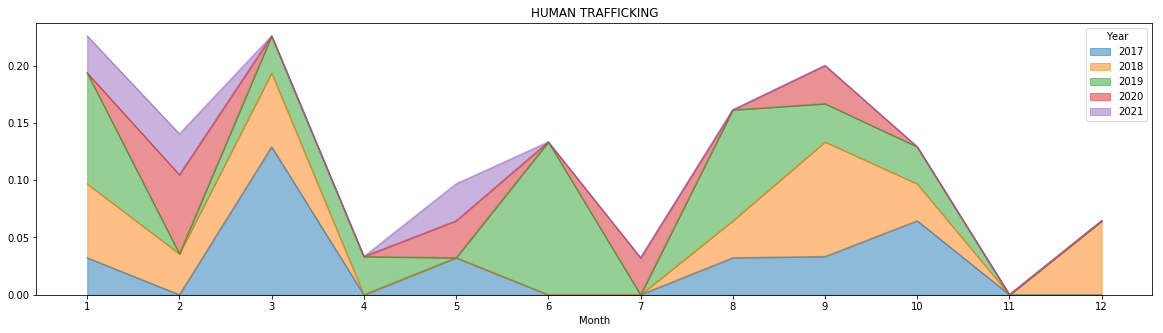

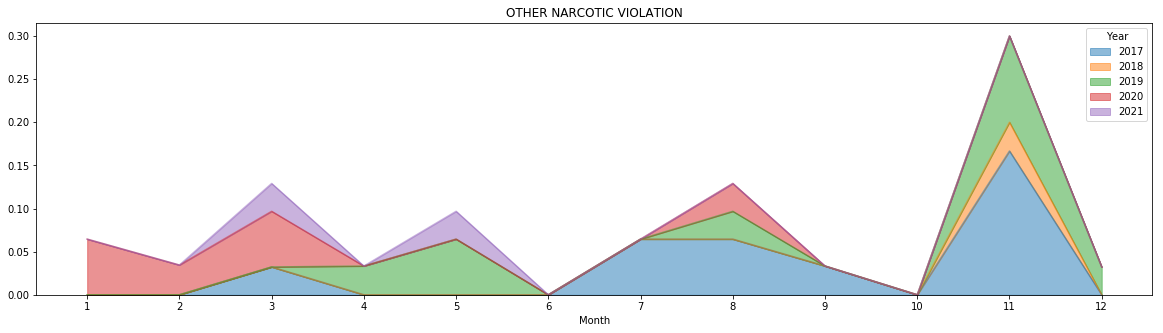

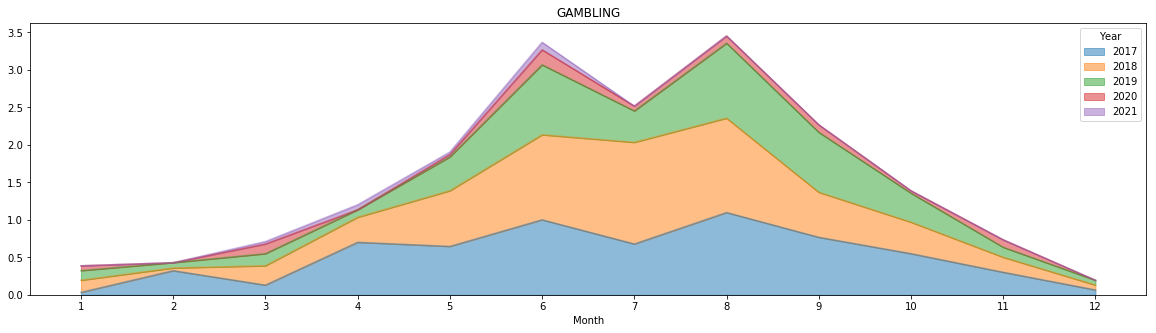

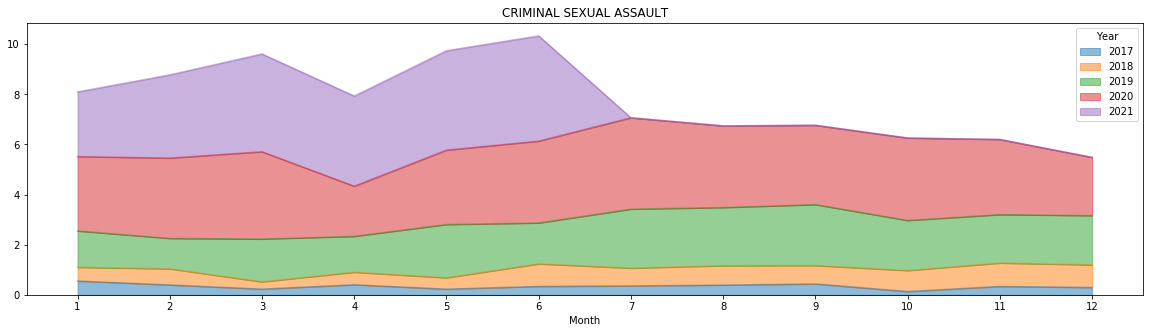

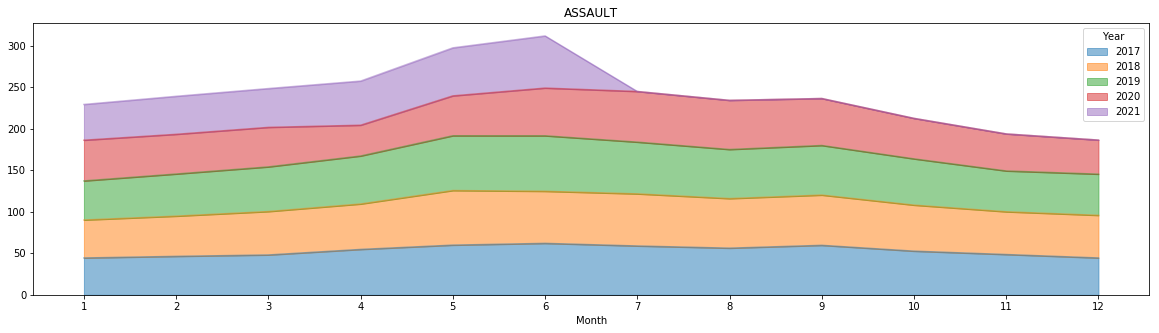

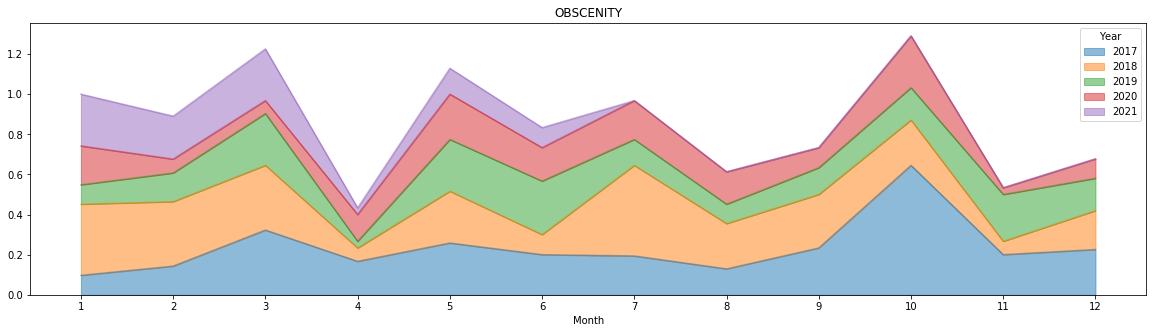

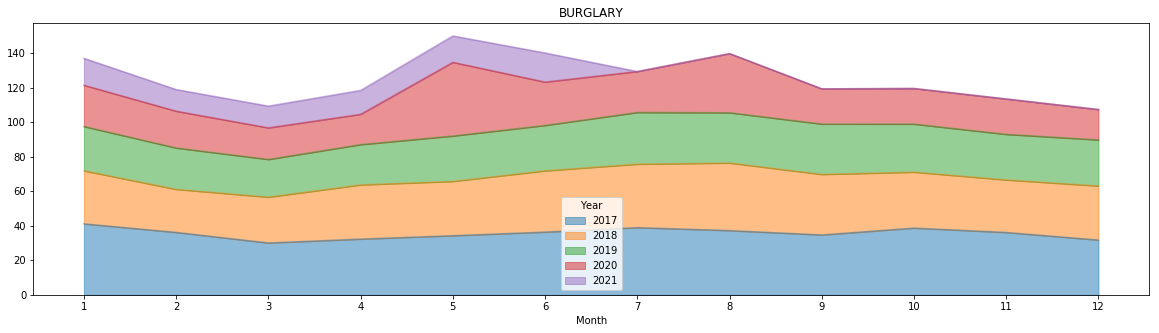

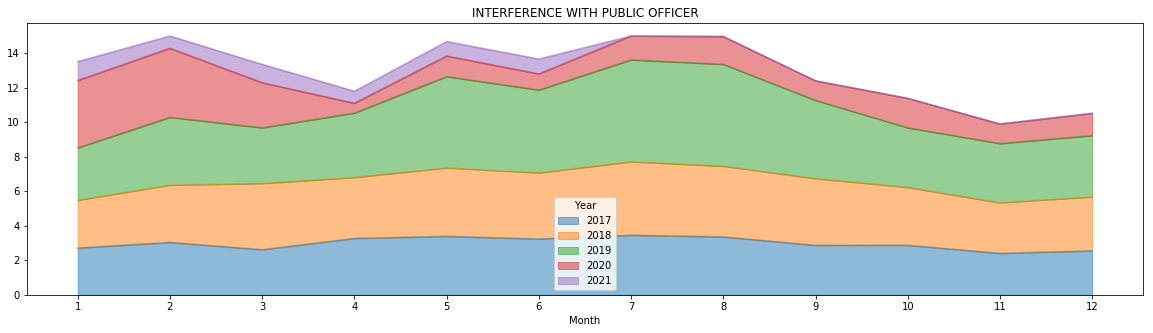

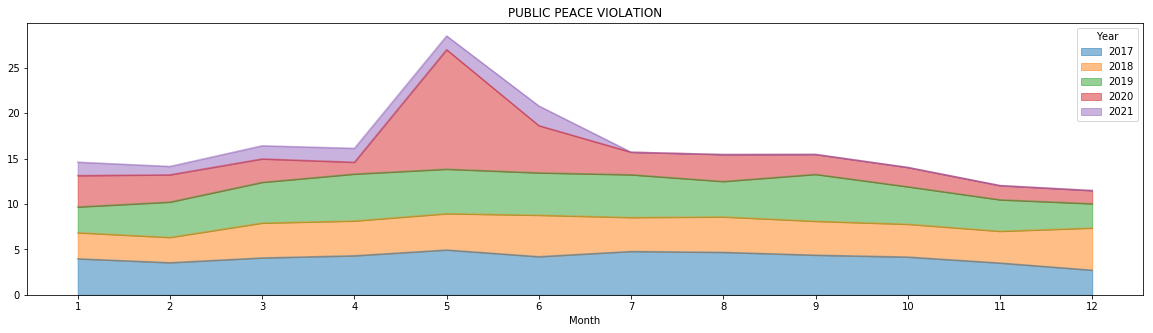

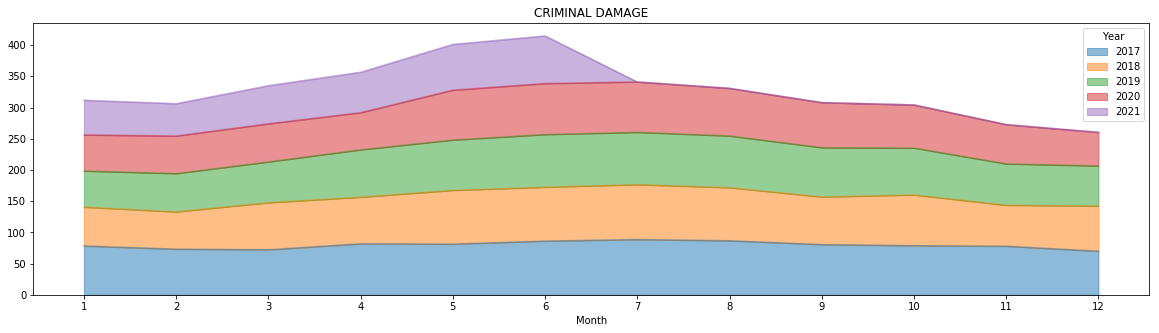

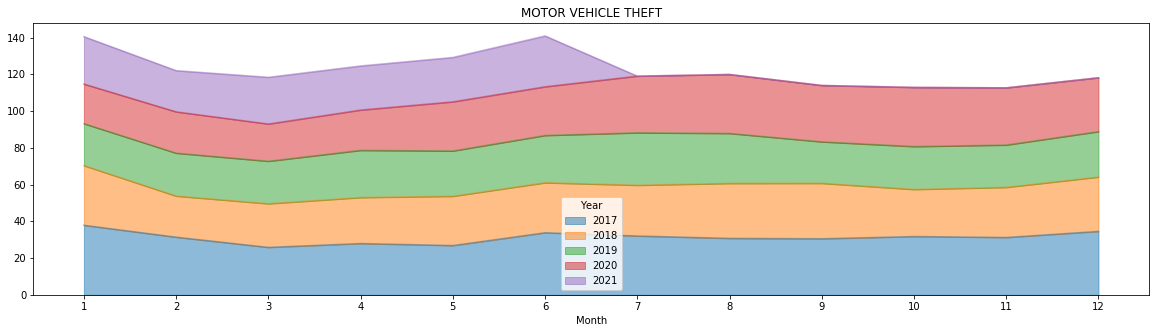

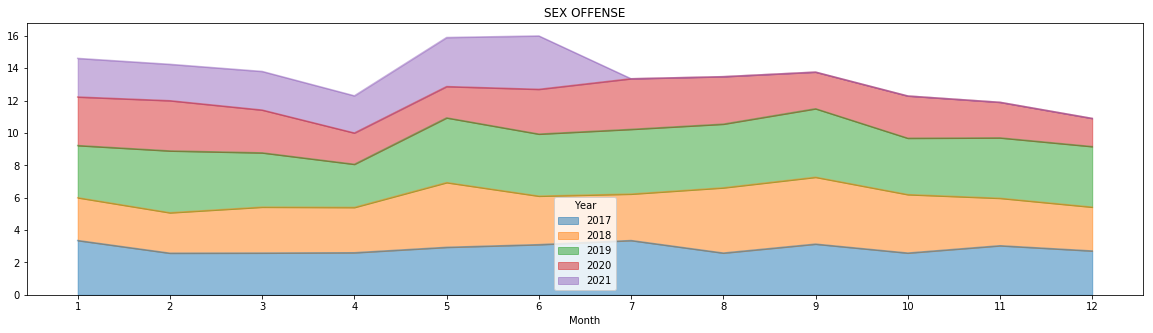

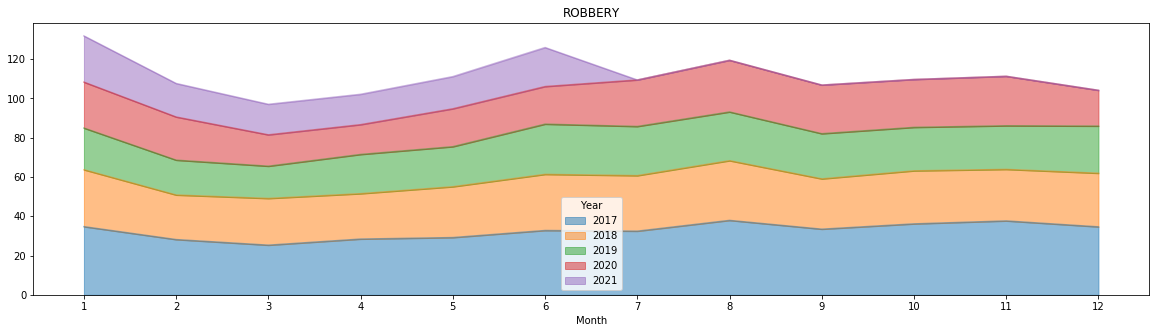

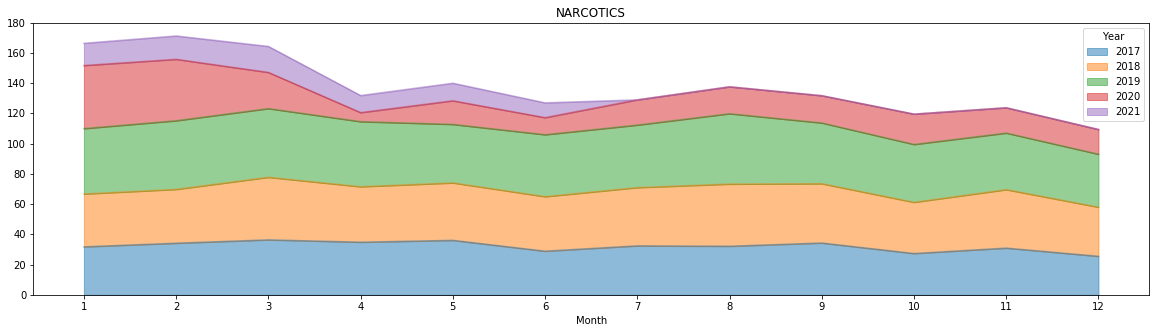

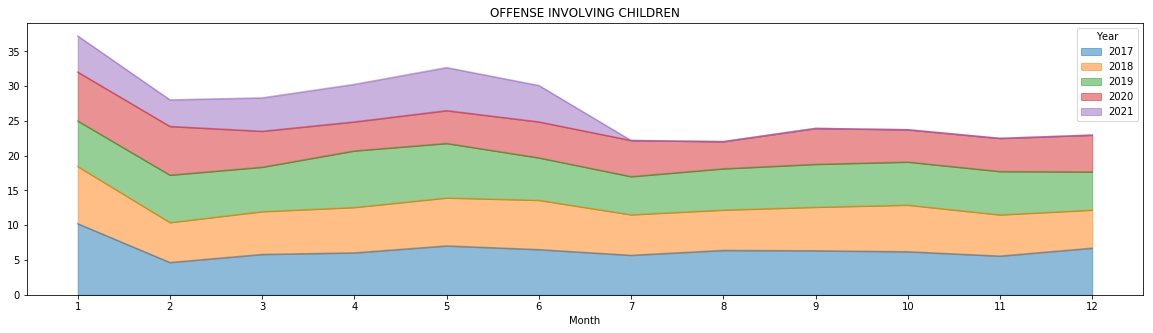

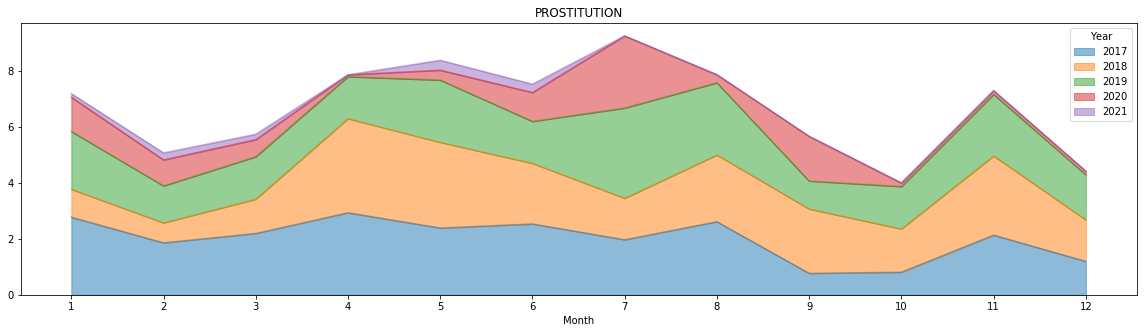

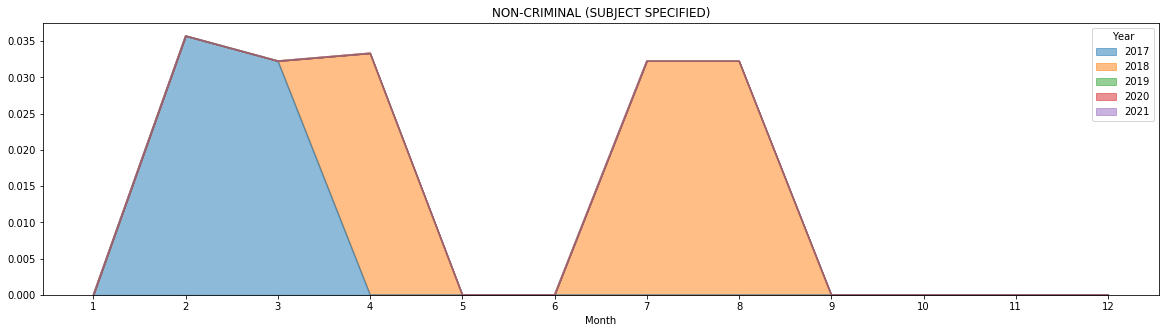

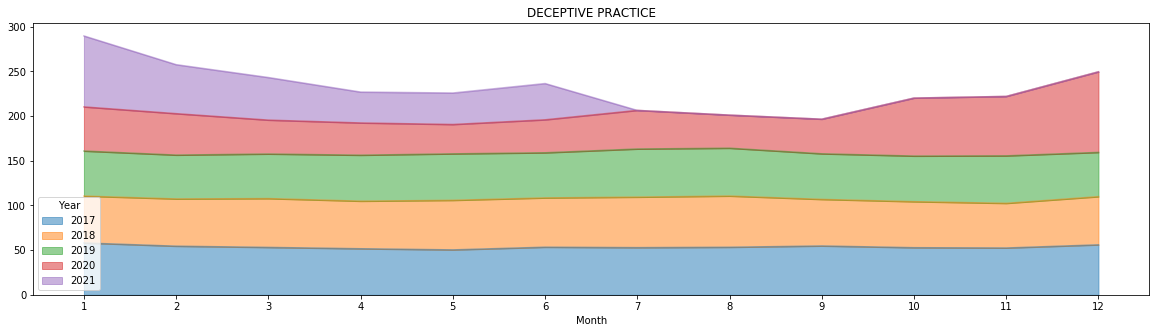

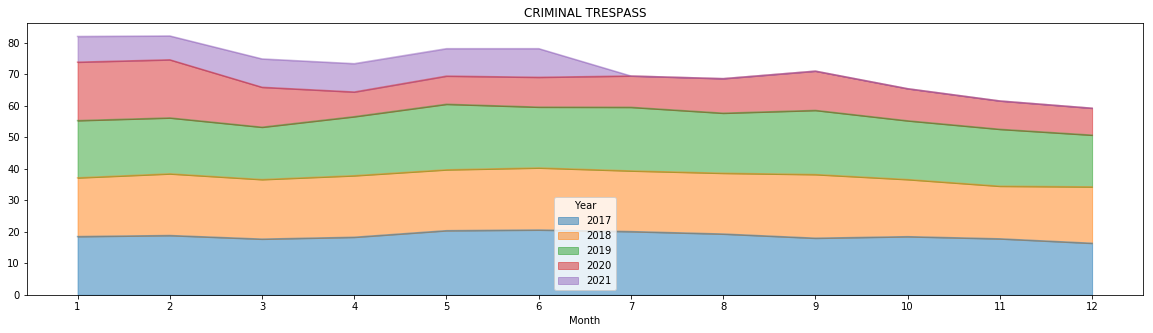

In [27]:
df_5d = df_5c.fillna(0)\
    .withColumn('Year', year('Date'))\
    .withColumn('Month', month('Date'))\
    .withColumn('Weekday', dayofweek('Date'))\
    .withColumn('Day', dayofmonth('Date'))\
    .filter(df_5c['Date'] < '2021-07-01')
df_5d = df_5d.filter(df_5d['Year'] >= 2017)

crimes = list(set(df_5c.columns) - set(['Date', 'Cases - Total', 'Deaths - Total']))
df_i = df_5d.toPandas().pivot_table(index='Month', columns='Year')
for i in crimes:
    df_i[i].plot(figsize=(20,5), kind='area', alpha=.5)
    plt.title(i)
    plt.xticks(list(range(1, 13)))
    plt.show()

In [28]:
crimes_dif = ['DECEPTIVE PRACTICE', 'NARCOTICS', 'BURGLARY', 'HOMICIDE', 'STALKING', 
          'INTERFERENCE WITH PUBLIC OFFICER', 'PROSTITUTION', 'ARSON', 'CRIMINAL SEXUAL ASSAULT', 
          'PUBLIC PEACE VIOLATION', 'GAMBLING', 'WEAPONS VIOLATION', 'LIQUOR LAW VIOLATION']
print('Crime type different from previous years:')
crimes_dif

Crime type different from previous years:


['DECEPTIVE PRACTICE',
 'NARCOTICS',
 'BURGLARY',
 'HOMICIDE',
 'STALKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'PROSTITUTION',
 'ARSON',
 'CRIMINAL SEXUAL ASSAULT',
 'PUBLIC PEACE VIOLATION',
 'GAMBLING',
 'WEAPONS VIOLATION',
 'LIQUOR LAW VIOLATION']

* Identify `crime type` (different from previous years) that might also be attributed to `Cases` or `Deaths`

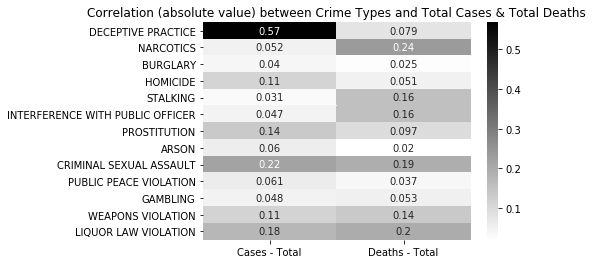

In [29]:
df_ii = df_5d.filter(df_5d['Date'] >= '2020-03-01').select(crimes_dif + ['Cases - Total'] + ['Deaths - Total']).toPandas()
correlation = df_ii.corr()[['Cases - Total', 'Deaths - Total']].iloc[:len(crimes_dif), :]

sns.heatmap(correlation.abs(), annot=True, cmap='binary')
plt.title('Correlation (absolute value) between Crime Types and Total Cases & Total Deaths')
plt.show()

In [30]:
crimes_corr = correlation[correlation.abs() > .1].dropna().index.tolist()
crimes_corr
print('Crime type different from previous years & might be attributed to Cases or Deaths:')
crimes_corr

Crime type different from previous years & might be attributed to Cases or Deaths:


['CRIMINAL SEXUAL ASSAULT', 'WEAPONS VIOLATION', 'LIQUOR LAW VIOLATION']

* Predict number of cases for `crime type` (different from previous years & might be attributed to Cases or Deaths) if covid didn't happen
     * `train`: 2017-01-01 ~ 2020-03-01 (onset of covid)
     * `test`: 2020-03-01 ~ 2021-07-01 
     * `features`: Month, Day, Weekday, Lag1 ~ Lag 7 of crime type cases

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
w = Window.orderBy('Date')

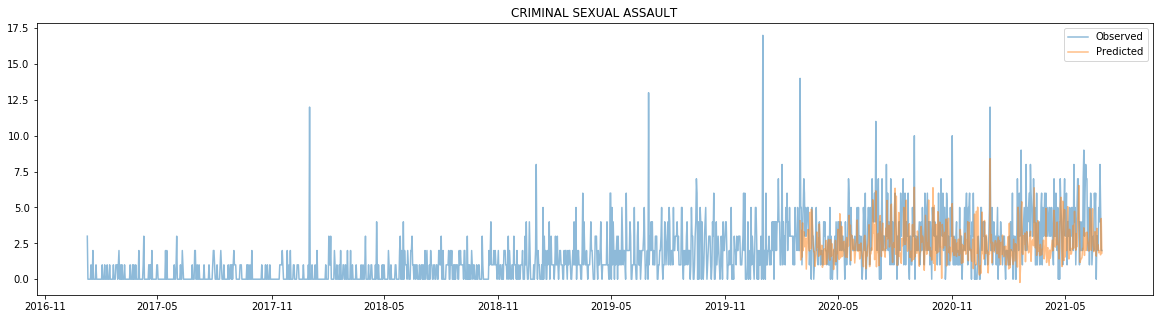

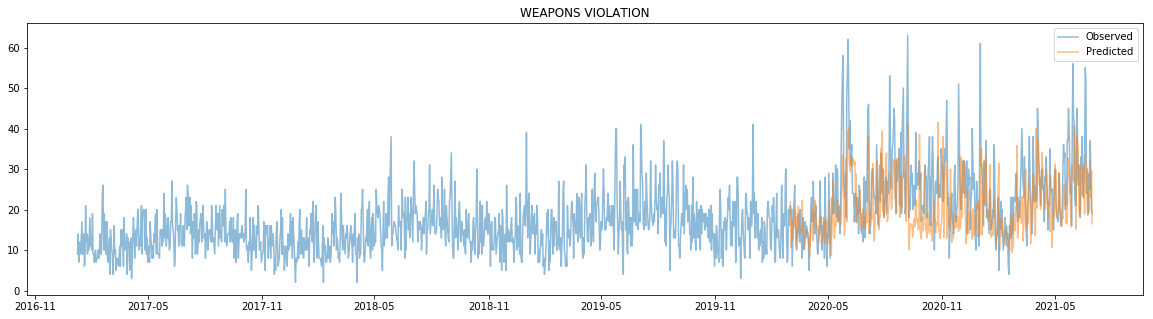

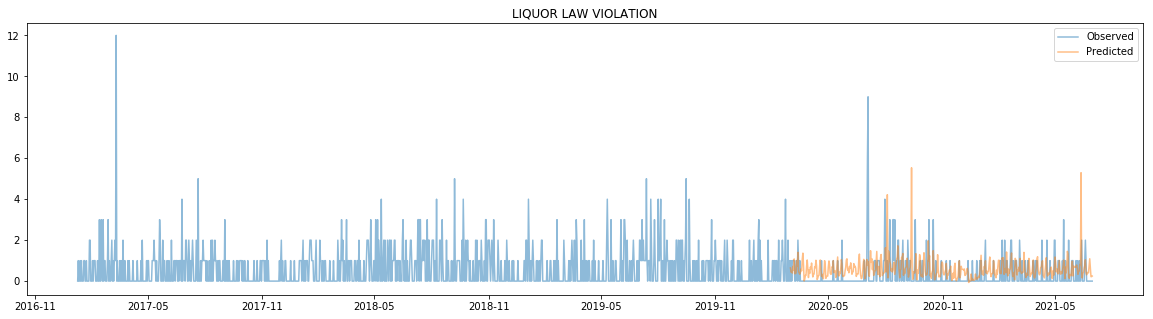

In [32]:
for i in crimes_corr: 
    dt = df_5d.select(i, 'Cases - Total', 'Deaths - Total', 'Date', 'Year', 'Month', 'Day', 'Weekday')\
        .withColumn('Lag 1', lag(i).over(w))\
        .withColumn('Lag 2', lag(i, count=2).over(w))\
        .withColumn('Lag 3', lag(i, count=3).over(w))\
        .withColumn('Lag 4', lag(i, count=4).over(w))\
        .withColumn('Lag 5', lag(i, count=5).over(w))\
        .withColumn('Lag 6', lag(i, count=6).over(w))\
        .withColumn('Lag 7', lag(i, count=7).over(w))\
        .dropna()
    
    dt = VectorAssembler(inputCols = ['Month'] + ['Day'] + ['Weekday'] + ['Lag %d' % i for i in range(1, 8)], outputCol = 'features').transform(dt)
    train = dt.filter(dt['Date'] < '2020-03-01')
    test = dt.filter(dt['Date'] >= '2020-03-01')
    
    model = GBTRegressor(labelCol=i).fit(train)
    evaluator = RegressionEvaluator(labelCol=i)
    pred = model.transform(test)
    
    plt.figure(figsize=(20,5))
    plt.plot(dt.toPandas().set_index('Date')[[i]], label='Observed', alpha=.5)
    plt.plot(pred.toPandas().set_index('Date')[['prediction']], label='Predicted', alpha=.5)
    plt.legend()
    plt.title(i)
    plt.show()

* Predict cases of `crime type` (different from previous years & might be attributed to Cases or Deaths)
     * `train`: 2020-03-01 (onset of covid) ~ 2021-03-01
     * `test`: 2021-03-01 ~ 2021-07-01 
     * `features`: Month, Day, Weekday, Lag1 ~ Lag 7 of crime type cases, Total cases, Total deaths
     * predictions:
         * `Cases` show relatively high predictivity for `CRIMINAL SEXUAL ASSAULT`, `WEAPONS VIOLATION`, and `LIQUOR LAW VIOLATION`
         * `Deaths` show relatively high predictivity for `CRIMINAL SEXUAL ASSAULT` and `LIQUOR LAW VIOLATION`, but relatively low predictivity for `WEAPONS VIOLATION`

RMSE: 2.38
MAE: 1.84


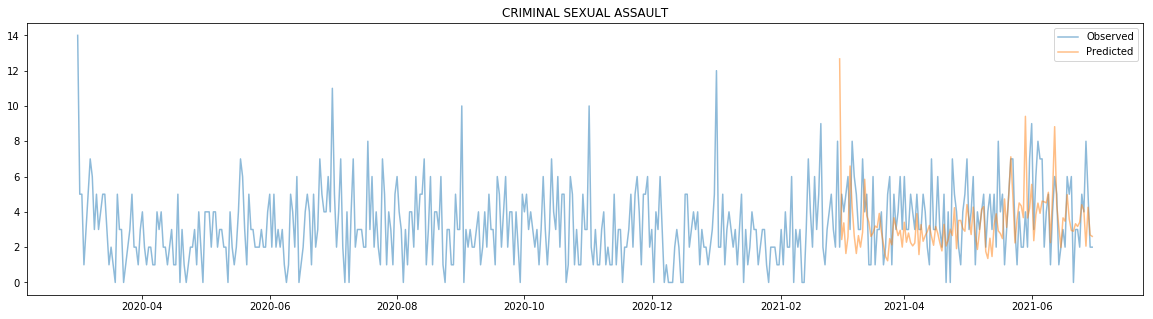

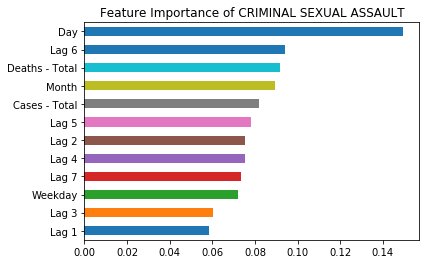

RMSE: 9.96
MAE: 7.93


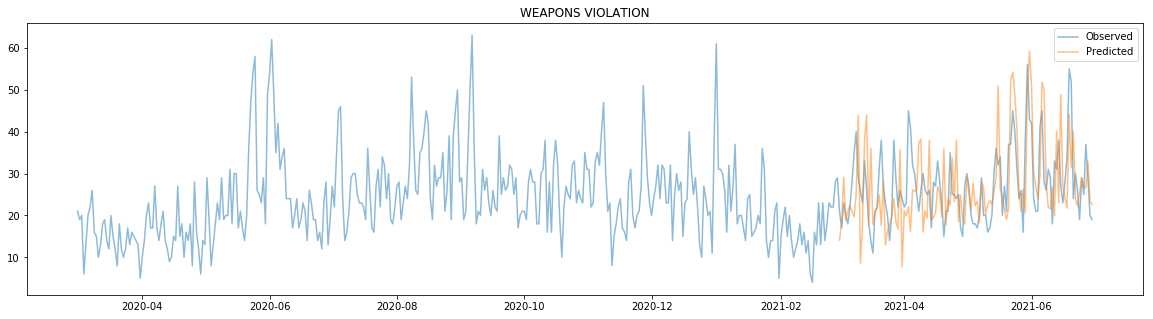

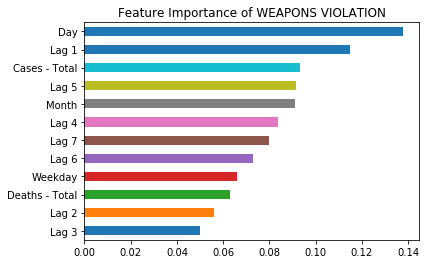

RMSE: 0.76
MAE: 0.56


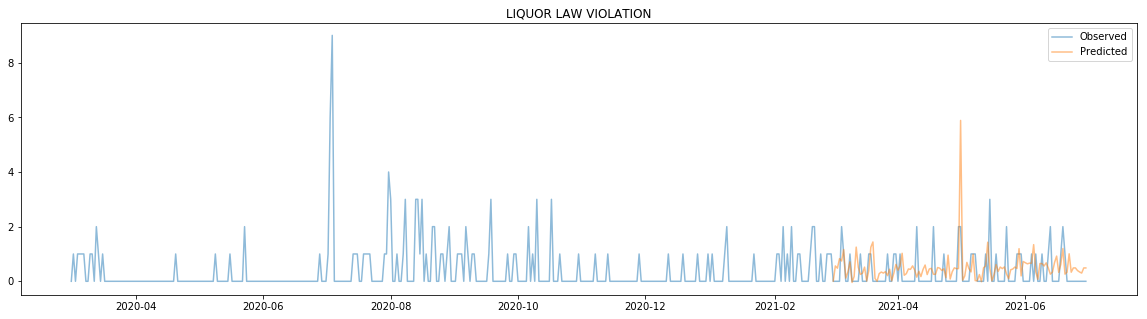

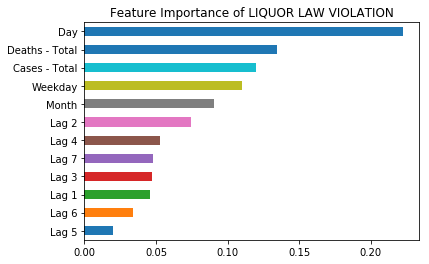

In [33]:
for i in crimes_corr:
    dt = df_5d.select(i, 'Cases - Total', 'Deaths - Total', 'Date', 'Year', 'Month', 'Day', 'Weekday')\
        .withColumn('Lag 1', lag(i).over(w))\
        .withColumn('Lag 2', lag(i, count=2).over(w))\
        .withColumn('Lag 3', lag(i, count=3).over(w))\
        .withColumn('Lag 4', lag(i, count=4).over(w))\
        .withColumn('Lag 5', lag(i, count=5).over(w))\
        .withColumn('Lag 6', lag(i, count=6).over(w))\
        .withColumn('Lag 7', lag(i, count=7).over(w))\
        .filter(df_5d['Date'] >= '2020-03-01')\
        .dropna()
    
    features = ['Month'] + ['Day'] + ['Weekday'] + ['Lag %d' % i for i in range(1, 8)] + ['Cases - Total'] + ['Deaths - Total']
    dt = VectorAssembler(inputCols=features, outputCol = 'features').transform(dt)
    train = dt.filter(dt['Date'] < '2021-03-01')
    test = dt.filter(dt['Date'] >= '2021-03-01')
    
    model = GBTRegressor(labelCol=i).fit(train)
    evaluator = RegressionEvaluator(labelCol=i)
    pred = model.transform(test)
    
    print('RMSE: %.2f' % evaluator.evaluate(pred))
    print('MAE: %.2f' % evaluator.evaluate(pred, {evaluator.metricName: "mae"}))
    
    plt.figure(figsize=(20,5))
    plt.plot(dt.toPandas().set_index('Date')[[i]], label='Observed', alpha=.5)
    plt.plot(pred.toPandas().set_index('Date')[['prediction']], label='Predicted', alpha=.5)
    plt.legend()
    plt.title(i)
    plt.show()
    
    pd.Series([model.featureImportances[i] for i in range(len(features))], index=features).sort_values().plot(kind='barh')
    plt.title('Feature Importance of ' + i)
    plt.show()